In [1]:
import pandas as pd
import re
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import numpy as np
import requests

In [2]:
import udf

# Dataset

## Request data from web

In [4]:
import urllib
import urllib.request
from bs4 import BeautifulSoup

#define URL for scraping
theurl = "https://www.americanrhetoric.com/barackobamaspeeches.htm"
thepage = urllib.request.urlopen(theurl)

#Cooking the Soup
soup = BeautifulSoup(thepage,"html.parser")

web_list=[]
#Scraping "Link" (href)
for a_href in soup.find_all("a", href=True):
    #print(a_href["href"])
    web_list.append(a_href["href"])

In [5]:
speech=[]
for i in web_list:
    if i.startswith("speeches"):
        speech.append(i)
speech_web=[]
for i in speech:
    if i.endswith('htm'):
        speech_web.append(i)

In [6]:
start = speech_web.index('speeches/barackobama/barackobamainauguraladdress.htm')
speech_president = speech_web[start:]

# remove replicate
new = []
for i in speech_president:
    if i not in new:
        new.append(i)

speech_url = []
for val in range(len(new)):
    speech_url.append("https://www.americanrhetoric.com/" + str(new[val])) 

In [7]:
len(speech_url)

427

## List Title and Speeches

In [8]:
headers = {
      'User-Agent':"Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; rv:2.0.1) Gecko/20100101 Firefox/4.0.1"
}

def extract_text(url):
    resp = requests.get(url, headers=headers)
    s = BeautifulSoup(resp.text, "lxml")
    title = s.title
    text = s.get_text(strip=True)
    return title, text
#speech_content = [extract_text(url) for url in speech_url]

In [9]:
speeches = [extract_text(url) for url in speech_url]
len(speeches)

427

In [10]:
speech_content = []
speech_title = []

for i in range(len(speeches)):
    speech_content.append(speeches[i][1])
    speech_title.append(speeches[i][0])

In [11]:
def title(title):
    title = str(title)
    title = title[title.find("Obama -")+len("Obama -"):title.find("</title>")]
    #title = title[title.find("-")+len("-"):]
    title = title[:title.find("(transcript-audio-video)")]
    title = title[:title.find("(text-audio-video)")].strip()
    return title
speech_title = [title(x) for x in speech_title]

In [12]:
## delete something like cd, pdf ...
def allowed(speech):
    allowed = speech[speech.find("transcribed directly from audio]")
                        +len("transcribed directly from audio]"):speech.find(
                        "Book/CDs by Michael E. Eidenmuller,")].strip()
    return allowed

speech_content = [allowed(speech) for speech in speech_content]

## List Date ( 2009.01.20 – 2017.01.20 )

In [13]:
year = ["2009","2010","2011","2012","2013","2014","2015","2016","2017"]

In [14]:
date_list = []
for i in range(len(year)):
    date_list.extend(soup.find_all(string=re.compile(year[i])))

In [15]:
no = ['Press Conference on 2010 Budget Sent to Congress','Announcement of 2012 Presidential Candidacy',
     'Honoring Golden State Warriors 2015 NBA Champs','Press Conference Following 2016 NATO Summit']
for i in range(len(no)):
    date_list.remove(no[i])
len(date_list)

434

In [16]:
date = date_list[date_list.index("20 Jan 2009"):]

In [17]:
date = [str(x) for x in date]

## Create a Dataframe

In [18]:
df_speech = pd.DataFrame({'date': date,'title':speech_title,'content':speech_content}
                         )
df_speech.head()

,date,title,content
0,20 Jan 2009,First Presidential Inaugural Addre,[Chief Justice John G. \r\n\t\tRoberts adminis...
1,24 Jan 2009,>American Rhetoric: Barack Obama: First Presid...,: First Presidential Weekly Address \r\n(01-24...
2,26 Jan 2009,Al-Arabiya Television Intervi,- Al-Arabiya Television InterviewBarackObamaAl...
3,04 Feb 2009,Remarks on Executive Compensati,- Remarks on Executive CompensationBarackObama...
4,09 Feb 2009,First Presidential Prime Time Press \r\nConferen,"Good \r\n\t\tevening, everybody. Please be sea..."


In [19]:
df_speech.iloc[0,2] = df_speech.iloc[0,2][df_speech.iloc[0,2].find("My fellow citizens:")
                                          +len("My fellow citizens:"):df_speech.iloc[0,2].find("(Drudge Report)")]

In [20]:
## Make some edition
df_speech.iloc[1,2] = df_speech.iloc[1,2][df_speech.iloc[1,2].find("[as prepared for delivery]") + 
                                               len("[as prepared for delivery]"):]
df_speech.iloc[1,1] = df_speech.iloc[1,1][df_speech.iloc[1,1].find(">American Rhetoric: Barack Obama:")
                                         +len(">American Rhetoric: Barack Obama:"):df_speech.iloc[1,1].find(
                                         "(01-24-0")].strip()

In [21]:
df_speech.head(5)

,date,title,content
0,20 Jan 2009,First Presidential Inaugural Addre,I stand here today humbled \r\n\t\tby the task...
1,24 Jan 2009,First Presidential Weekly Address,We begin this year and this \r\n\t\tAdministra...
2,26 Jan 2009,Al-Arabiya Television Intervi,- Al-Arabiya Television InterviewBarackObamaAl...
3,04 Feb 2009,Remarks on Executive Compensati,- Remarks on Executive CompensationBarackObama...
4,09 Feb 2009,First Presidential Prime Time Press \r\nConferen,"Good \r\n\t\tevening, everybody. Please be sea..."


## Clean data

In [22]:
from nltk import WordNetLemmatizer
StopWords = stopwords.words("english")
StopWords.extend(["u","from"])

def clean_text(text):
    """
    This function takes as input a text on which several 
    NLTK algorithms will be applied in order to preprocess it
    """
    tokens = word_tokenize(text)
    # Remove the punctuations
    tokens = [word for word in tokens if word.isalpha()]
    # Lower the tokens
    tokens = [word.lower() for word in tokens]
    # Remove stopword
    tokens = [word for word in tokens if not word in StopWords]
    # Lemmatize
    lemma = WordNetLemmatizer()
    tokens = [lemma.lemmatize(word, pos = "v") for word in tokens]
    tokens = [lemma.lemmatize(word, pos = "n") for word in tokens]
    #list to string
    text = " ".join(tokens)
    return text

In [23]:
clean_content = [clean_text(i) for i in df_speech["content"].values.tolist() ]
df_speech["content_clean"] = clean_content
df_speech.head()

,date,title,content,content_clean
0,20 Jan 2009,First Presidential Inaugural Addre,I stand here today humbled \r\n\t\tby the task...,stand today humble task u grateful trust besto...
1,24 Jan 2009,First Presidential Weekly Address,We begin this year and this \r\n\t\tAdministra...,begin year administration midst unprecedented ...
2,26 Jan 2009,Al-Arabiya Television Intervi,- Al-Arabiya Television InterviewBarackObamaAl...,television television interview hisham melhemd...
3,04 Feb 2009,Remarks on Executive Compensati,- Remarks on Executive CompensationBarackObama...,remark executive compensationbarackobamaremark...
4,09 Feb 2009,First Presidential Prime Time Press \r\nConferen,"Good \r\n\t\tevening, everybody. Please be sea...",good even everybody please take question tonig...


In [24]:
# Extract nouns from speeches
def nouns_extract(cont):
    nouns = [] #empty to array to hold all nouns
    cont = StringToList(cont)
    for word,pos in nltk.pos_tag(cont):
        if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS'):
            nouns.append(word)
            string_nouns = ListToString(nouns)
    return string_nouns

nouns = [nouns_extract(x) for x in clean_content]
df_speech["content_nouns"] = nouns
df_speech.head(5)

,date,title,content,content_clean,content_nouns
0,20 Jan 2009,First Presidential Inaugural Addre,I stand here today humbled \r\n\t\tby the task...,stand today humble task u grateful trust besto...,stand today task u trust bestow sacrifice bear...
1,24 Jan 2009,First Presidential Weekly Address,We begin this year and this \r\n\t\tAdministra...,begin year administration midst unprecedented ...,year administration midst crisis call action w...
2,26 Jan 2009,Al-Arabiya Television Intervi,- Al-Arabiya Television InterviewBarackObamaAl...,television television interview hisham melhemd...,television television interview hisham house w...
3,04 Feb 2009,Remarks on Executive Compensati,- Remarks on Executive CompensationBarackObama...,remark executive compensationbarackobamaremark...,remark executive compensationbarackobamaremark...
4,09 Feb 2009,First Presidential Prime Time Press \r\nConferen,"Good \r\n\t\tevening, everybody. Please be sea...",good even everybody please take question tonig...,question tonight speak briefly state economy n...


# K-means Cluster

## Train a model

In [25]:
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.preprocessing            import normalize
from sklearn import cluster
import matplotlib.cm      as cm
import seaborn            as sns
from sklearn.metrics                  import silhouette_samples, silhouette_score
from wordcloud                        import WordCloud

# Map Viz
import folium
#import branca.colormap as cm
from branca.element import Figure

In [27]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_speech["content_nouns"])
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names_out())

final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(5, 0)

427 rows


,0,1,2,3,4,5,6,7,8,9,...,417,418,419,420,421,422,423,424,425,426
robert,0.265739,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
nation,0.190066,0.000000,0.000000,0.0,0.010113,0.114169,0.058876,0.086828,0.115353,0.079425,...,0.013794,0.129722,0.082316,0.000000,0.074283,0.052999,0.069253,0.000000,0.006673,0.0
oath,0.177159,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.095908,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
icy,0.126652,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
generation,0.119274,0.071105,0.010421,0.0,0.006800,0.000000,0.047503,0.035926,0.000000,0.038145,...,0.000000,0.058147,0.018449,0.004735,0.062432,0.014254,0.000000,0.021608,0.044867,0.0


In [30]:
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = cluster.KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , tol = 0.0001
                               , random_state = 1
                               , algorithm = 'lloyd')

        kmeans_results.update( {k : kmeans.fit(data)} )
        
    return kmeans_results

def printAvg(avg_dict):
    for avg in sorted(avg_dict.keys(), reverse=True):
        print("Avg: {}\tK:{}".format(avg.round(4), avg_dict[avg]))
        
def plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg):
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(8, 6)
    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--") # The vertical line for average silhouette score of all the values
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title(("Silhouette analysis for K = %d" % n_clusters), fontsize=10, fontweight='bold')
    
    y_lower = 10
    sample_silhouette_values = silhouette_samples(df, kmeans_labels) # Compute the silhouette scores for each sample
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Label the silhouette plots with their cluster numbers at the middle
        y_lower = y_upper + 10  # Compute the new y_lower for next plot. 10 for the 0 samples
    plt.show()
    
        
def silhouette(kmeans_dict, df, plot=False):
    df = df.to_numpy()
    avg_dict = dict()
    for n_clusters, kmeans in kmeans_dict.items():      
        kmeans_labels = kmeans.predict(df)
        silhouette_avg = silhouette_score(df, kmeans_labels) # Average Score for all Samples
        avg_dict.update( {silhouette_avg : n_clusters} )
    
        if(plot): plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg)

In [31]:
# Running Kmeans
k = 20
kmeans_results = run_KMeans(k, final_df)

## Elbow Method

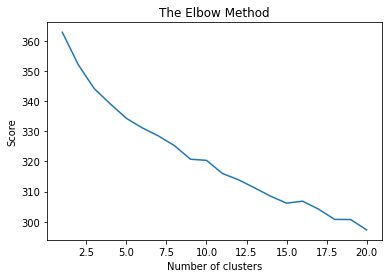

In [32]:
distortion_score = []
for i in range(1,k + 1):
    kmeans = cluster.KMeans(n_clusters = i
                               , init = 'k-means++'
                               , n_init = 10
                               , tol = 0.0001
                               , random_state = 1
                               , algorithm = 'lloyd')
    kmeans.fit(tf_idf)
    distortion_score.append(kmeans.inertia_)
plt.plot(range(1,k + 1 ),distortion_score)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.savefig('elbow.png')
plt.show()

## Silhouette Analysis

/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


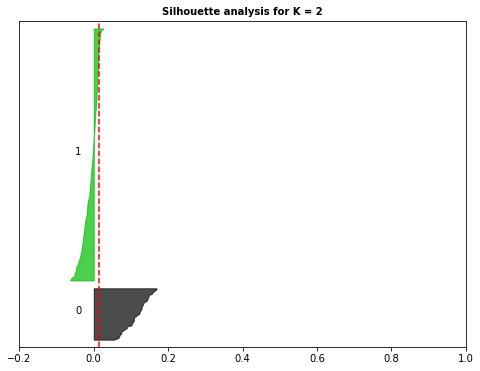

/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


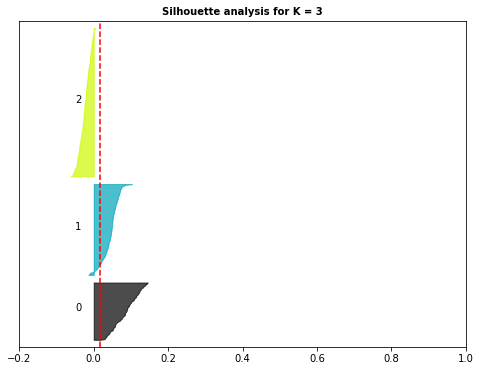

/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


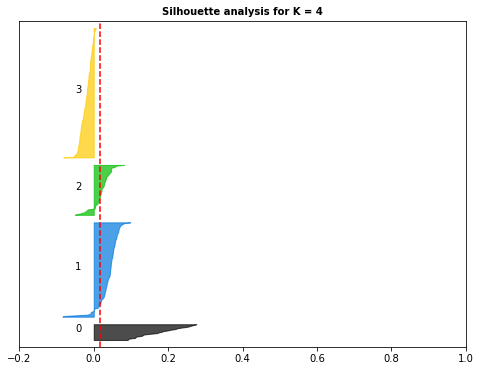

/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


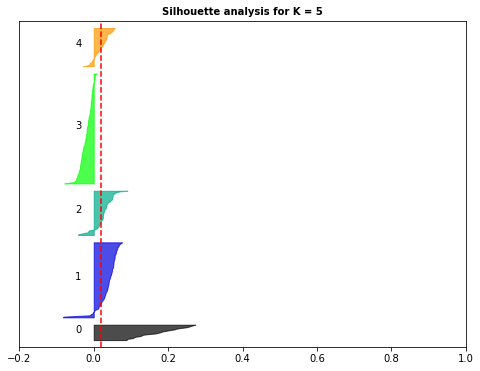

/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


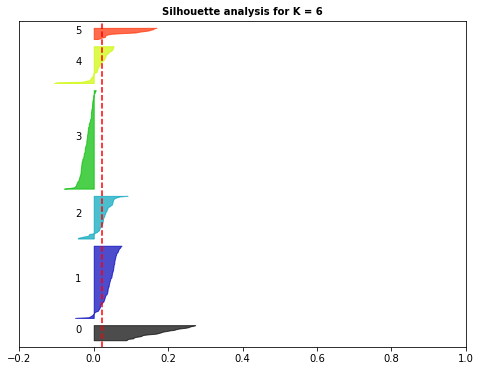

/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


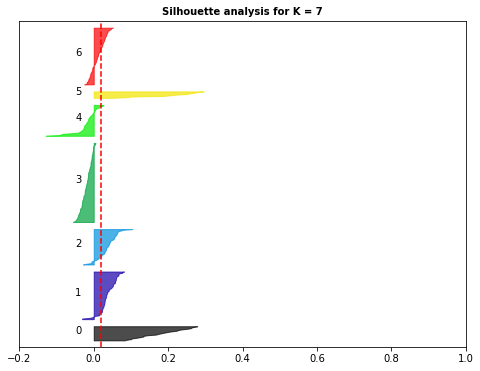

/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


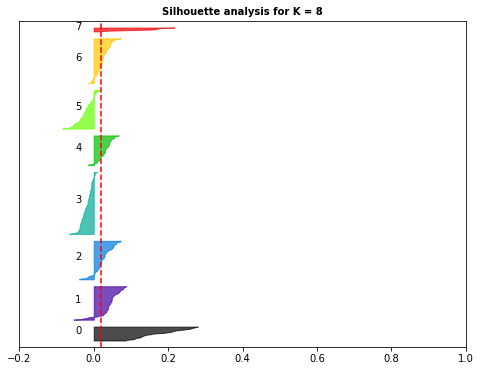

/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


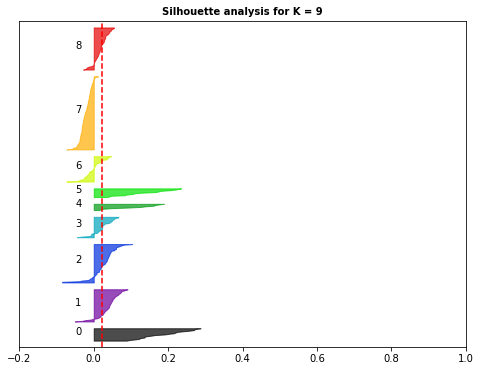

/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


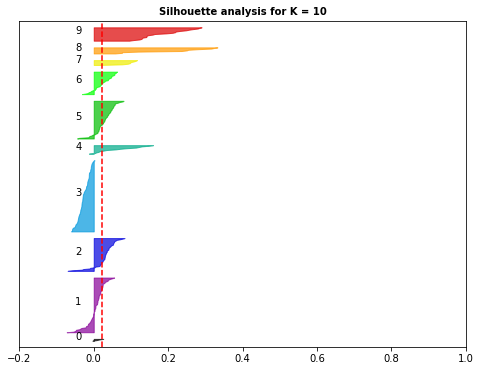

/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


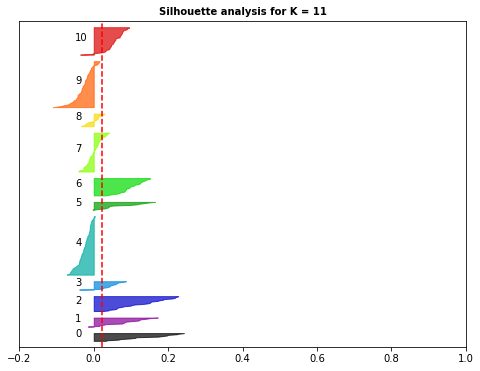

/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


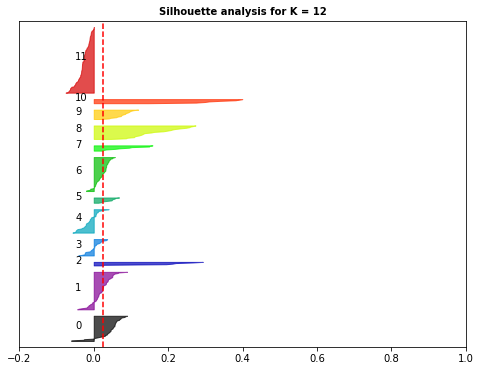

/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


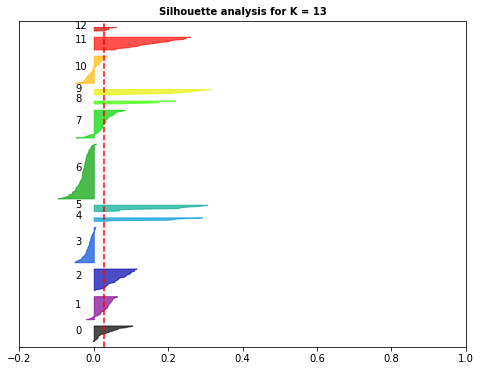

/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


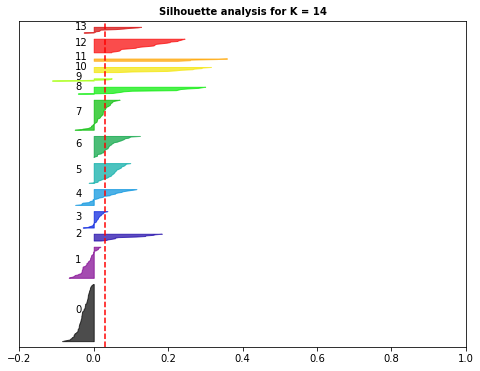

/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


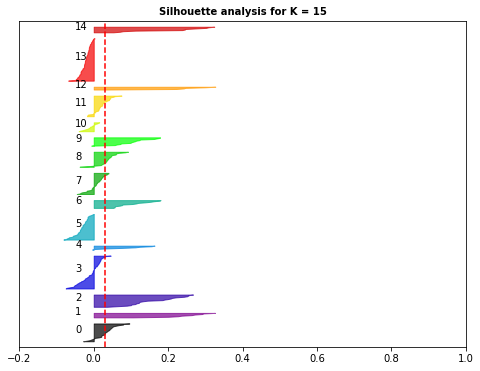

/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


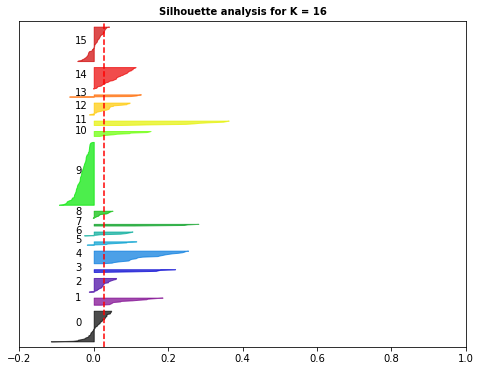

/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


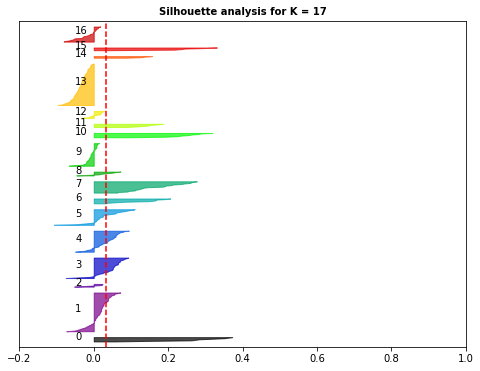

/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


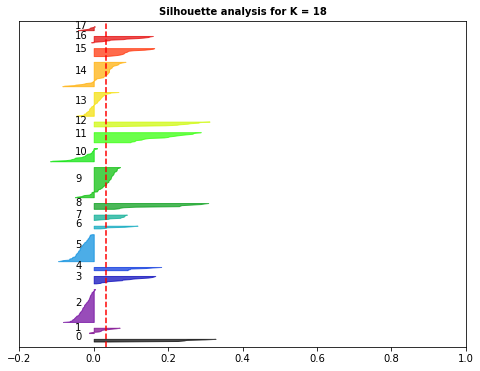

/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


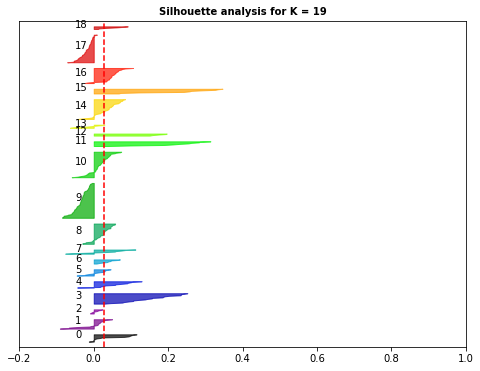

/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


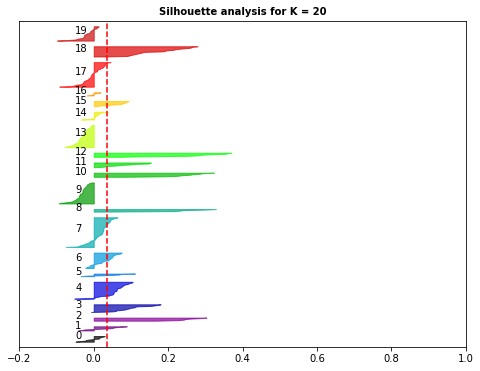

In [33]:
silhouette(kmeans_results, final_df, plot=True)

In [34]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/liyitong/opt/anaconda3/envs/mda2022/lib/python3.

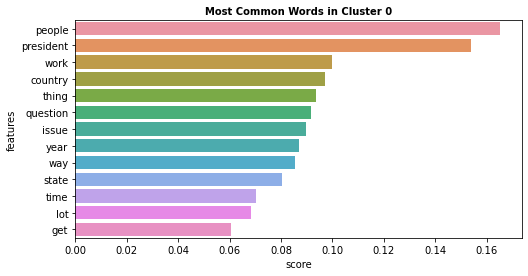

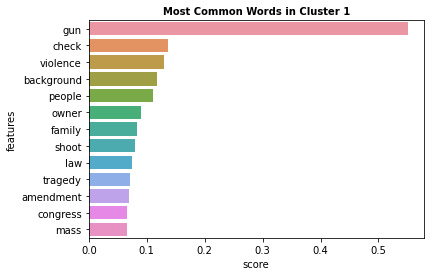

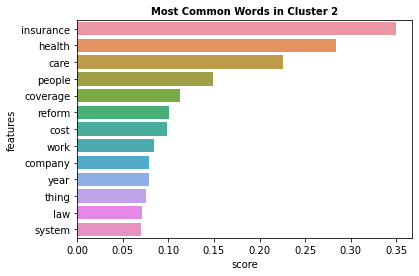

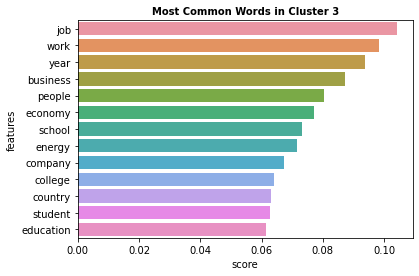

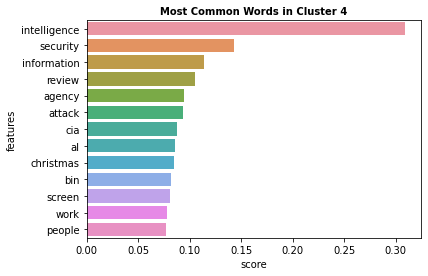

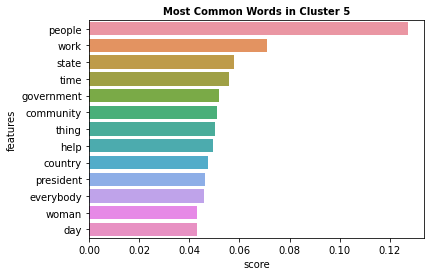

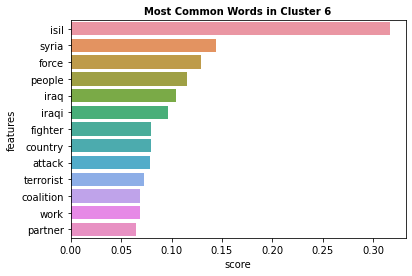

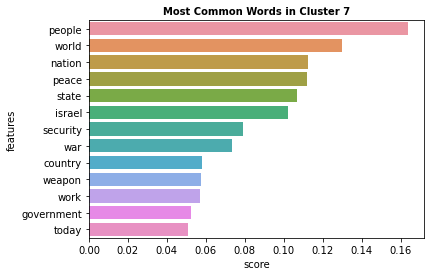

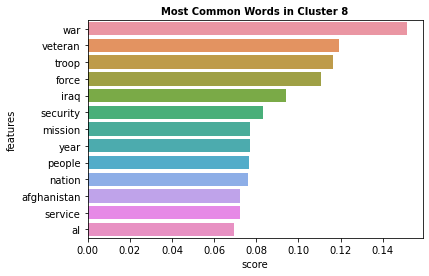

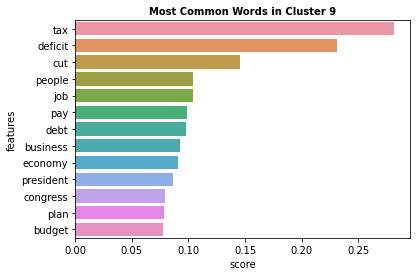

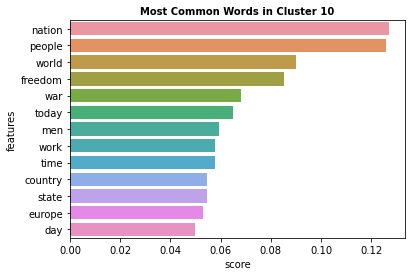

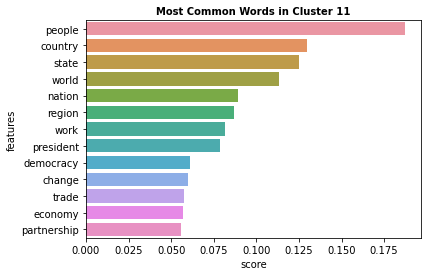

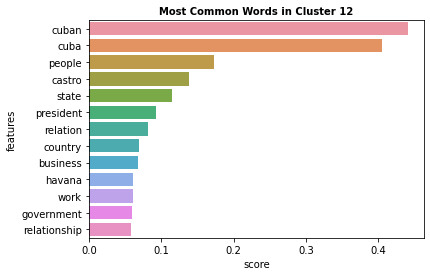

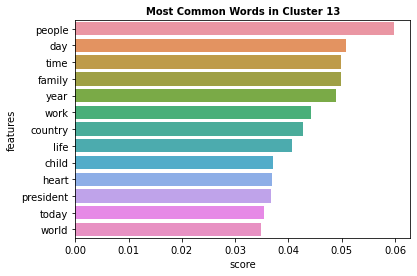

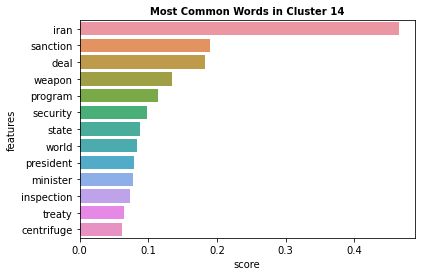

In [35]:
best_result = 15 ##16, 17, 18, 19, 20
kmeans = kmeans_results.get(best_result)

final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

## Display

In [36]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

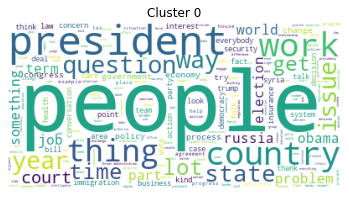

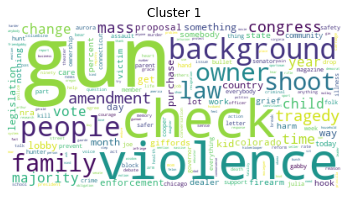

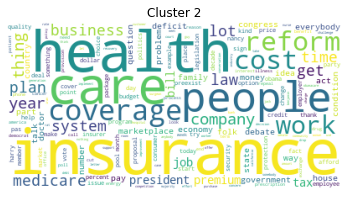

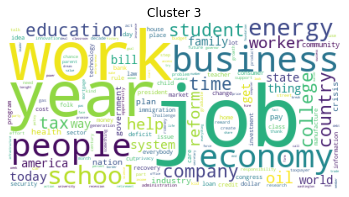

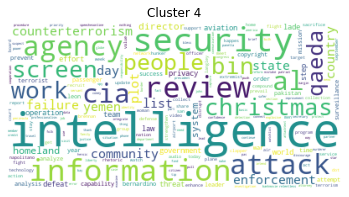

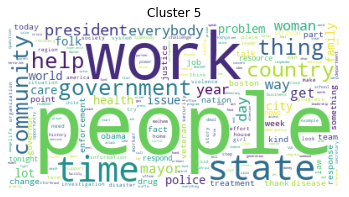

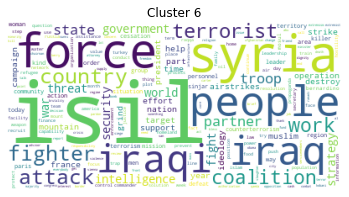

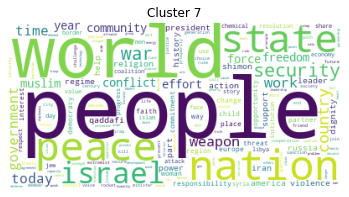

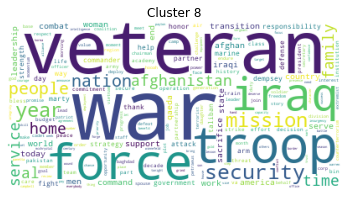

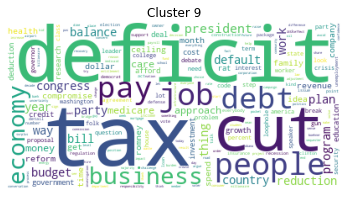

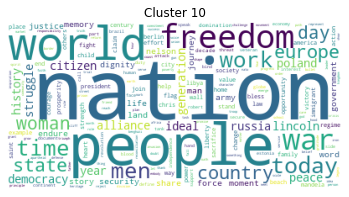

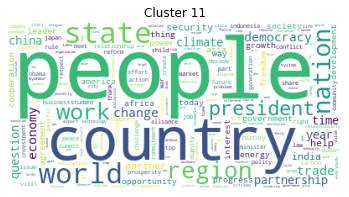

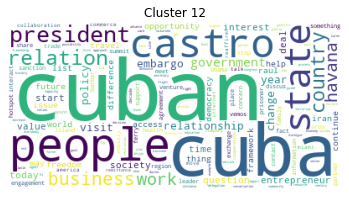

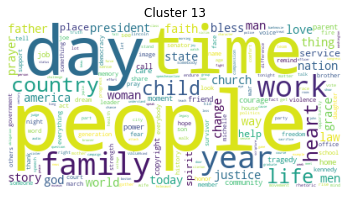

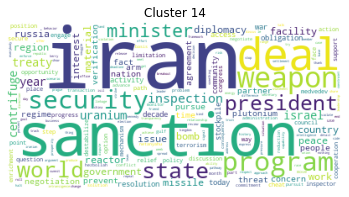

In [37]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)

# Topic Modelling Time Series

## Set MALLET Path

In [49]:
path_to_mallet = 'mallet-2.0.8/bin/mallet'

## Import Packages

In [50]:
import little_mallet_wrapper
import seaborn
import glob
from pathlib import Path
import pandas as pd
import random
pd.options.display.max_colwidth = 100

### Process Speech

In [51]:
training_data = [little_mallet_wrapper.process_string(text, numbers='remove') for text in df_speech['content_nouns']]

### Get Original Speech

In [52]:
original_speech = [title for title in df_speech['content_clean']]

### Get Dataset Statistics

In [53]:
little_mallet_wrapper.print_dataset_stats(training_data)

Number of Documents: 427
Mean Number of Words per Document: 817.3
Vocabulary Size: 11759


## Training the Topic Model

### Set Number of Topics

We need to make a variable `num_topics` and assign it the number of topics we want returned.

In [107]:
num_topics = 30

### Set Training Data

In [108]:
training_data = training_data

### Set Other MALLET File Paths

In [109]:
#Change to your desired output directory
output_directory_path = 'topic-model-output'

Path(f"{output_directory_path}").mkdir(parents=True, exist_ok=True)

path_to_training_data           = f"{output_directory_path}/training.txt"
path_to_formatted_training_data = f"{output_directory_path}/mallet.training"
path_to_model                   = f"{output_directory_path}/mallet.model.{str(num_topics)}"
path_to_topic_keys              = f"{output_directory_path}/mallet.topic_keys.{str(num_topics)}"
path_to_topic_distributions     = f"{output_directory_path}/mallet.topic_distributions.{str(num_topics)}"

### Train Topic Model

Then we're going to train our topic model with `little_mallet_wrapper.quick_train_topic_model()`. 

In [110]:
little_mallet_wrapper.quick_train_topic_model(path_to_mallet,
                                                                     output_directory_path,
                                                                     num_topics,
                                                                     training_data)

Importing data...
Complete
Training topic model...


Mallet LDA: 30 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 3972
total tokens: 348986
<10> LL/token: -8.726
<20> LL/token: -8.31449
<30> LL/token: -8.18111
<40> LL/token: -8.10107

0	0.16667	government work today community state information system value cooperation world share partner interest order create area internet approach network asia 
1	0.16667	deal iran program concern fact sanction state conversation weapon issue point side situation year work prevent talk mention consequence understand 
2	0.16667	gun people violence police way shoot background check crime victim act day mass owner country amendment fact child feel death 
3	0.16667	war security attack iraq troop country threat world people force syria partner work community year help part men mission state 
4	0.16667	school year time parent child job day family tonight thank graduate get money part experience everything care news effort guy 
5	0.16667	crisis home market work system credit reform responsibil

<110> LL/token: -7.93601
<120> LL/token: -7.93052
<130> LL/token: -7.91976
<140> LL/token: -7.91842

0	0.16667	government work information community today world technology system network partner share internet step order infrastructure organization threat access office increase 
1	0.16667	deal iran program weapon sanction year agreement concern support issue month fact option arm world prevent regime access situation argument 
2	0.16667	gun people violence police shoot check background law crime enforcement tragedy community owner hand mass majority child victim show safety 
3	0.16667	war country people security attack iraq troop state year intelligence threat work force community part partner support world syria coalition 
4	0.16667	time child day school year parent thank family support graduate care tonight let job challenge work experience men others nothing 
5	0.16667	crisis bank economy system home market recovery reform work act street consumer help today credit responsibility lo

[beta: 0.01426] 
<210> LL/token: -7.88092
[beta: 0.01535] 
<220> LL/token: -7.88677
[beta: 0.01579] 
<230> LL/token: -7.88579
[beta: 0.01596] 
<240> LL/token: -7.88273

0	0.1753	government information work technology company use privacy system internet network sector today security threat share community world day agency attack 
1	0.11683	iran deal sanction weapon program year world prevent support regime concern arm agreement fact congress decade access work threat path 
2	0.11315	gun violence people police law shoot enforcement crime background check community drug tragedy owner officer prevent mass change vote majority 
3	0.29171	people war security country attack year force iraq government troop world work support threat america action state part terrorist time 
4	0.29211	child time year school parent day kid support thank graduate today family tonight help story life responsibility let father nothing 
5	0.17512	crisis bank economy reform system market recovery loan consumer street

[beta: 0.01606] 
<310> LL/token: -7.86768
[beta: 0.01609] 
<320> LL/token: -7.86494
[beta: 0.01614] 
<330> LL/token: -7.8514
[beta: 0.01611] 
<340> LL/token: -7.84708

0	0.12809	government information technology company privacy sector world network system work threat today internet agency cyber use phone access month data 
1	0.09899	iran sanction deal weapon program year world regime support prevent agreement concern government fact arm bomb decade congress access resolution 
2	0.10253	gun violence law police enforcement people background check drug community crime shoot owner vote victim officer majority prevent change mass 
3	0.36332	people security attack war force support country threat troop iraq state government work year terrorist action leadership qaeda help nation 
4	0.35451	child time parent school day kid support responsibility year thank nothing need tell mom member success family life week someone 
5	0.15937	crisis economy bank reform recovery system market act home loan c

[beta: 0.01624] 
<410> LL/token: -7.81969
[beta: 0.01623] 
<420> LL/token: -7.81651
[beta: 0.01635] 
<430> LL/token: -7.82264
[beta: 0.01646] 
<440> LL/token: -7.82464

0	0.09133	government information technology privacy company sector network internet security cyber threat use world place access phone surveillance data cybersecurity agency 
1	0.10056	iran deal sanction weapon program security year region world arm regime threat fact use government agreement support prevent place resolution 
2	0.10175	gun violence law police people drug crime check shoot community background enforcement majority officer family tragedy owner kid mass prevent 
3	0.37433	people security force war support attack effort government troop state iraq partner threat action country work mission terrorist strategy qaeda 
4	0.29059	child time school parent life responsibility day year story kid member thank support washington care mom success ask challenge someone 
5	0.1528	economy crisis bank reform system busine

[beta: 0.01655] 
<510> LL/token: -7.80433
[beta: 0.01661] 
<520> LL/token: -7.80209
[beta: 0.01665] 
<530> LL/token: -7.80176
[beta: 0.01659] 
<540> LL/token: -7.79609

0	0.08673	government information privacy company program technology intelligence sector network threat system security cyber work agency world phone surveillance access data 
1	0.08524	iran deal sanction weapon program year world security regime government fact arm bomb threat region support prevent war negotiation decade 
2	0.09649	gun violence law police community crime drug check background family shoot enforcement officer people owner department change majority vote mass 
3	0.3689	people security war force support state troop government iraq attack effort threat country partner community qaeda mission action work afghanistan 
4	0.26161	child school parent day time kid life success story responsibility member care support washington need someone ask side teach matter 
5	0.1274	bank crisis economy recovery reform syst

[beta: 0.0167] 
<610> LL/token: -7.79423
[beta: 0.01662] 
<620> LL/token: -7.79192
[beta: 0.0167] 
<630> LL/token: -7.79094
[beta: 0.01663] 
<640> LL/token: -7.78986

0	0.06492	government information privacy company technology program sector security internet threat world use phone capability network cyber agency data cybersecurity access 
1	0.08052	iran deal sanction weapon program security world region year agreement regime threat support prevent bomb community arm access opportunity fact 
2	0.11009	gun violence law community police family shoot check drug enforcement crime background people officer owner majority tragedy change mass kid 
3	0.35331	people security force war support government troop iraq effort attack state work mission action threat woman partner qaeda community men 
4	0.24263	child school parent time support kid life day story need success mom washington week thank letter experience nothing year member 
5	0.12465	economy bank crisis system business market recovery r

[beta: 0.01683] 
<710> LL/token: -7.78157
[beta: 0.01691] 
<720> LL/token: -7.78598
[beta: 0.01684] 
<730> LL/token: -7.77885
[beta: 0.01684] 
<740> LL/token: -7.78444

0	0.07108	government information privacy company security sector threat intelligence technology cyber network world internet program surveillance system phone cybersecurity agency way 
1	0.08645	iran deal weapon sanction program world security year region regime threat war arm agreement community fact state access partner negotiation 
2	0.11052	gun violence law people police community check crime background family drug shoot enforcement owner change majority congress tragedy kid officer 
3	0.34564	people force security war support effort state troop iraq government partner attack work action mission end woman men qaeda afghanistan 
4	0.22106	child school parent life kid story support responsibility week day success need teacher thing ask experience pas senator washington thank 
5	0.12804	economy crisis business bank sys

[beta: 0.01692] 
<810> LL/token: -7.77354
[beta: 0.01689] 
<820> LL/token: -7.77502
[beta: 0.01695] 
<830> LL/token: -7.77411
[beta: 0.01708] 
<840> LL/token: -7.77666

0	0.07498	government information privacy company technology program sector security threat work cyber attack network surveillance phone internet world place today access 
1	0.08509	iran deal weapon sanction program security world year region state regime support prevent community agreement threat material arm fact negotiation 
2	0.09715	gun violence law police family shoot crime check community drug background enforcement people officer owner majority change mass kid tragedy 
3	0.34024	people force war security support troop effort attack partner iraq work mission action government afghanistan region woman transition qaeda threat 
4	0.18739	child school parent kid life story washington responsibility support graduate talk need week day someone mom secretary treatment success teach 
5	0.13084	bank crisis business reform 

[beta: 0.017] 
<910> LL/token: -7.77081
[beta: 0.01697] 
<920> LL/token: -7.76808
[beta: 0.01692] 
<930> LL/token: -7.76951
[beta: 0.0169] 
<940> LL/token: -7.76895

0	0.09431	government information company privacy technology program sector today threat security phone internet world call cyber network attack work surveillance consumer 
1	0.09351	iran deal weapon sanction program world security year state region war regime community agreement decade material arm prevent pursue threat 
2	0.11382	gun violence law police community family check background crime enforcement drug shoot officer child tragedy owner kid congress majority prevent 
3	0.31321	force people war security support state troop iraq mission effort partner attack government afghanistan strategy action qaeda transition woman leadership 
4	0.16662	child school story parent life kid support thank class someone responsibility share graduate mom need success treatment care ask friend 
5	0.14385	bank crisis business economy reco

Complete


([['government',
   'information',
   'company',
   'privacy',
   'technology',
   'sector',
   'security',
   'program',
   'world',
   'network',
   'threat',
   'system',
   'internet',
   'phone',
   'surveillance',
   'cyber',
   'consumer',
   'cybersecurity',
   'access',
   'today'],
  ['iran',
   'deal',
   'weapon',
   'sanction',
   'program',
   'security',
   'year',
   'world',
   'region',
   'agreement',
   'regime',
   'community',
   'threat',
   'state',
   'arm',
   'support',
   'partner',
   'decade',
   'diplomacy',
   'fact'],
  ['gun',
   'violence',
   'law',
   'police',
   'community',
   'family',
   'check',
   'enforcement',
   'shoot',
   'background',
   'crime',
   'majority',
   'drug',
   'officer',
   'owner',
   'kid',
   'tragedy',
   'congress',
   'mass',
   'child'],
  ['war',
   'people',
   'security',
   'force',
   'support',
   'state',
   'troop',
   'iraq',
   'effort',
   'mission',
   'partner',
   'government',
   'woman',
   'attack'

## Display Topics and Top Words

In [111]:
topics = little_mallet_wrapper.load_topic_keys(path_to_topic_keys)

for topic_number, topic in enumerate(topics):
    print(f"Topic {topic_number}\n\n{topic}\n")

Topic 0

['government', 'information', 'company', 'privacy', 'technology', 'sector', 'security', 'program', 'world', 'network', 'threat', 'system', 'internet', 'phone', 'surveillance', 'cyber', 'consumer', 'cybersecurity', 'access', 'today']

Topic 1

['iran', 'deal', 'weapon', 'sanction', 'program', 'security', 'year', 'world', 'region', 'agreement', 'regime', 'community', 'threat', 'state', 'arm', 'support', 'partner', 'decade', 'diplomacy', 'fact']

Topic 2

['gun', 'violence', 'law', 'police', 'community', 'family', 'check', 'enforcement', 'shoot', 'background', 'crime', 'majority', 'drug', 'officer', 'owner', 'kid', 'tragedy', 'congress', 'mass', 'child']

Topic 3

['war', 'people', 'security', 'force', 'support', 'state', 'troop', 'iraq', 'effort', 'mission', 'partner', 'government', 'woman', 'attack', 'action', 'afghanistan', 'nation', 'transition', 'qaeda', 'men']

Topic 4

['child', 'parent', 'school', 'life', 'class', 'kid', 'story', 'care', 'talk', 'support', 'experience', '

## Display Top Speech For Topic

### Load Topic Distributions

In [112]:
topic_distributions = little_mallet_wrapper.load_topic_distributions(path_to_topic_distributions)

In [113]:
speech_dict = dict(zip(training_data, original_speech))

In [114]:
def display_top_speech_per_topic(topic_number=0, number_of_documents=5):
    
    print(f"Topic {topic_number}\n\n{topics[topic_number]}\n")

    for probability, document in little_mallet_wrapper.get_top_docs(training_data, topic_distributions, topic_number, n=number_of_documents):
        print(round(probability, 4), speech_dict[document] + "\n")
    return

Here, we can use the function to find out speeches related to each topic

In [115]:
display_top_speech_per_topic(topic_number=1, number_of_documents=5)

Topic 1

['iran', 'deal', 'weapon', 'sanction', 'program', 'security', 'year', 'world', 'region', 'agreement', 'regime', 'community', 'threat', 'state', 'arm', 'support', 'partner', 'decade', 'diplomacy', 'fact']

0.6041 good afternoon everybody today unite state together ally partner reach historic understand iran fully implement prevent obtain nuclear president greater responsibility security american people convince framework lead final comprehensive deal make country ally world long time come islamic republic iran advance nuclear program decade time take office iran operate thousand centrifuge produce material nuclear bomb iran conceal covert nuclear facility make clear prepare resolve issue diplomatically iran come table serious way happen rally world impose toughest sanction history sanction profound impact iranian sanction alone could stop nuclear program help bring iran negotiate table diplomatic effort world stand u join negotiate table major power unite kingdom france germany

### Show Topic Words in Context of Full Speech

In [116]:
from IPython.display import Markdown, display
import re

def display_bolded_topic_words_in_context(topic_number=3, number_of_documents=3, custom_words=None):

    print(f"Topic {topic_number}\n\n{topics[topic_number]}\n")

    for probability, document in little_mallet_wrapper.get_top_docs(training_data, topic_distributions, topic_number, n=number_of_documents):

        probability = f"\n\n**{probability}**"
        original_text = speech_dict[document]
        original_text_lowered = original_text.lower()
        topic_words = topics[topic_number]
        topic_words = custom_words if custom_words != None else topic_words

        for word in topic_words:
            if word in original_text_lowered:
                original_text = re.sub(f"\\b{word}\\b", f"**{word.upper()}**", original_text, flags=re.I)

        display(Markdown(probability)), display(Markdown(original_text))
    return

In [117]:
display_bolded_topic_words_in_context(topic_number=1, number_of_documents=4)

✨Topic 1✨

['iran', 'deal', 'weapon', 'sanction', 'program', 'security', 'year', 'world', 'region', 'agreement', 'regime', 'community', 'threat', 'state', 'arm', 'support', 'partner', 'decade', 'diplomacy', 'fact']



✨✨✨

**0.6040666442827941**

good afternoon everybody today unite **STATE** together ally **PARTNER** reach historic understand **IRAN** fully implement prevent obtain nuclear president greater responsibility **SECURITY** american people convince framework lead final comprehensive **DEAL** make country ally **WORLD** long time come islamic republic **IRAN** advance nuclear **PROGRAM** **DECADE** time take office **IRAN** operate thousand centrifuge produce material nuclear bomb **IRAN** conceal covert nuclear facility make clear prepare resolve issue diplomatically **IRAN** come table serious way happen rally **WORLD** impose toughest **SANCTION** history **SANCTION** profound impact iranian **SANCTION** alone could stop nuclear **PROGRAM** help bring **IRAN** negotiate table diplomatic effort **WORLD** stand u join negotiate table major power unite kingdom france germany russia china well european **YEAR** ago take first step towards framework **DEAL** stop progress nuclear **PROGRAM** roll back key area recall time skeptic argue **IRAN** would cheat could verify compliance interim **AGREEMENT** would fail instead succeed exactly intend **IRAN** meet obligation eliminate stockpile dangerous nuclear material inspection **PROGRAM** increase continue negotiation see could achieve comprehensive many month tough principled **DIPLOMACY** achieve framework **DEAL** good **DEAL** **DEAL** meet core objective framework would cut every pathway **IRAN** could take develop nuclear **WEAPON** **IRAN** face strict limitation **PROGRAM** **IRAN** also agree robust intrusive inspection transparency **REGIME** ever negotiate nuclear **PROGRAM** history **DEAL** base trust base unprecedented key detail finalize next three month nothing agree everything agree basic outline **DEAL** work **IRAN** able pursue bomb use plutonium develop plutonium core reactor arak dismantle replace spend fuel facility ship **IRAN** life reactor **IRAN** build new reactor **IRAN** reprocess fuel exist reactor **DEAL** shut path bomb use enrich uranium **IRAN** agree instal centrifuge reduce **IRAN** longer enrich uranium fordow facility **IRAN** enrich uranium advance centrifuge least next **YEAR** vast majority stockpile enrich uranium estimate indicate **IRAN** two three month away potentially acquire raw material could use single nuclear bomb **DEAL** **IRAN** agree stockpile material need build **WEAPON** even violate **DEAL** next **DECADE** least **IRAN** would minimum **YEAR** away acquire enough material bomb strict limitation stockpile last **DEAL** provide best possible defense ability pursue nuclear **WEAPON** covertly secret international inspector unprecedented access iranian nuclear facility entire supply chain **SUPPORT** nuclear **PROGRAM** uranium mill provide raw material centrifuge production storage facility **SUPPORT** **PROGRAM** **IRAN** cheat **WORLD** know see something suspicious inspect past effort weaponize **PROGRAM** address **DEAL** **IRAN** face inspection country **DEAL** address path potential iranian nuclear bomb strict limit **PROGRAM** **DECADE** additional restriction build new facility stockpile material last **YEAR** unprecedented transparency measure last **YEAR** indeed permanent member nuclear treaty **IRAN** never permit develop nuclear return action international **COMMUNITY** agree provide **IRAN** relief certain **SANCTION** **SANCTION** international **SANCTION** impose unite nation **SECURITY** council relief phase **IRAN** take step adhere **DEAL** **IRAN** violate **DEAL** **SANCTION** snap back place meanwhile american **SANCTION** **IRAN** **SUPPORT** terrorism human right abuse ballistic missile **PROGRAM** continue fully let reemphasize work yet do **DEAL** sign end june negotiator continue work detail framework fully implement detail matter backslide part iranian verification inspection mechanism meet specification nuclear **SECURITY** expert **DEAL** get do **IRAN** follow framework negotiator agree able resolve one greatest **THREAT** **SECURITY** importance issue instruct negotiator fully brief congress american people substance **DEAL** welcome robust debate week month come confident show **DEAL** good **SECURITY** unite **STATE** ally **FACT** three option address nuclear **PROGRAM** first reach robust verifiable **DEAL** like one peacefully prevent **IRAN** obtain nuclear second option bomb nuclear facility thereby start another war middle east set back **PROGRAM** **YEAR** word set back fraction time **DEAL** set back meanwhile ensure **IRAN** would race ahead try build could pull negotiation try get country go along continue **SANCTION** currently place add additional one hope best know every time do **IRAN** capitulate instead advance **PROGRAM** short order breakout timeline would eliminate nuclear **ARM** race **REGION** could trigger uncertainty word third option lead u quickly back decision whether take military action idea go inside go simply dismantle **PROGRAM** demand **WORLD** work history show u **IRAN** show willingness eliminate aspect **PROGRAM** maintain peaceful purpose even face unprecedented **SANCTION** negotiation collapse unite **STATE** reject majority **WORLD** consider fair **DEAL** scientist nuclear expert suggest would give u confidence develop nuclear **WEAPON** doubtful even keep current international **SANCTION** hear inevitable critic **DEAL** sound ask simple question really think verifiable **DEAL** fully implement back major power worse option risk another war middle east worse do almost two **DECADE** **IRAN** move forward nuclear **PROGRAM** without robust inspection think answer always insist necessary prevent **IRAN** acquire nuclear **WEAPON** also know diplomatic solution best way get do offer comprehensive last solution best option far always possibility **IRAN** may try cheat **DEAL** future framework inspection transparency make far likely know try cheat future president preserve option currently available **DEAL** iranian people want reaffirm say since begin presidency will engage basis mutual interest mutual respect **DEAL** offer prospect relief **SANCTION** impose violation international law since supreme leader issue fatwa development nuclear **WEAPON** framework give **IRAN** opportunity verify **PROGRAM** **FACT** peaceful demonstrate **IRAN** comply international obligation fully rejoin **COMMUNITY** nation thereby fulfil extraordinary talent aspiration iranian people would good **IRAN** would good course **DEAL** alone even fully implement end deep division mistrust two country difficult history u concern remain respect iranian behavior long **IRAN** continue sponsorship terrorism **SUPPORT** proxy destabilize middle east **THREAT** friend ally like israel make mistake remain vigilant counter action stand secret israeli prime minister agree whether unite **STATE** move forward peaceful resolution iranian issue **FACT** prime minister netanyahu look effective way ensure **IRAN** get nuclear **WEAPON** best option believe nuclear expert confirm importantly speak prime minister today make clear daylight daylight come **SUPPORT** **SECURITY** concern destabilize policy **THREAT** toward israel direct national **SECURITY** team consult closely new israeli government come week month strengthen **SECURITY** cooperation israel make clear unshakeable commitment also speak king saudi arabia reaffirm commitment **SECURITY** **PARTNER** gulf invite leader six country make gulf cooperation council saudi arabia unite arab emirate kuwait oman qatar bahrain meet camp david spring discus strengthen **SECURITY** cooperation resolve multiple conflict cause much hardship instability throughout middle worth remember congress bipartisan basis play critical role current **IRAN** policy help shape **SANCTION** **REGIME** apply much pressure **IRAN** ultimately force table come day week administration engage congress play play constructive oversight role begin effort speak leader house senate conversation underscore issue stake bigger politics matter war peace evaluate base **FACT** ultimately best american people national **SECURITY** simply **DEAL** administration **IRAN** **DEAL** **IRAN** unite **STATE** america major power **WORLD** include closest ally congress kill **DEAL** base expert analysis without offer reasonable alternative unite **STATE** blame failure **DIPLOMACY** international unity collapse path conflict american people understand solid majority **SUPPORT** diplomatic resolution iranian nuclear issue understand instinctively word president kennedy face far greater **THREAT** communism say u never negotiate fear let u never fear american people remember height cold war president like nixon reagan strike historic **ARM** control **AGREEMENT** soviet union far dangerous adversary despite **FACT** adversary threaten destroy country way life mean **AGREEMENT** perfect end **THREAT** make **WORLD** safer good **DEAL** **IRAN** like express thank international **PARTNER** steadfastness cooperation able speak earlier today close ally prime minister cameron president hollande chancellor merkel reaffirm stand behalf nation want express thank tireless mean tireless secretary **STATE** john kerry entire negotiate team work hard make progress represent best tradition american **DIPLOMACY** work work yet do success guarantee historic opportunity prevent spread nuclear **WEAPON** **IRAN** peacefully international **COMMUNITY** firmly behind u seize god bless god bless unite **STATE** america

✨✨✨

**0.5603558114258566**

eement final announcementbarackobamairan nuclear accord announcementdelivered july addressyour browser **SUPPORT** audio pdftoday two **YEAR** negotiation unite **STATE** together international **PARTNER** achieve something **DECADE** animosity comprehensive **DEAL** iranthat prevent obtain nuclear **DEAL** demonstrate american **DIPLOMACY** bring real meaningful change change make country **WORLD** safer secure **DEAL** also line tradition american leadership **YEAR** since president kennedy stand american people say u never negotiate fear let u never fear speak need discussion unite **STATE** soviet union lead effort restrict spread nuclear day risk catastrophic nuclear war two super power time risk nuclear **WEAPON** spread country particularly middle east volatile **REGION** america negotiate position strength principle stop spread nuclear **WEAPON** **REGION** **DEAL** international **COMMUNITY** able verify islamic republic **IRAN** develop nuclear **DEAL** meet every single one bottom line establish achieve framework earlier spring every pathway nuclear **WEAPON** cut inspection transparency **REGIME** necessary verify objective put place **DEAL** **IRAN** produce highly enrich uranium plutonium form raw material necessary nuclear **DEAL** **IRAN** remove instal centrifuge machine necessary produce highly enrich uranium bomb store constant international supervision **IRAN** use advance centrifuge produce enrich uranium next **DECADE** **IRAN** also get rid percent stockpile enrich put perspective **IRAN** currently stockpile could produce nuclear **WEAPON** **DEAL** stockpile reduce fraction would require single **WEAPON** stockpile limitation last **DEAL** **IRAN** modify core reactor arak produce plutonium agree ship spend fuel reactor country lifetime reactor least next **YEAR** **IRAN** build new **DEAL** first time position verify commitment mean **DEAL** build trust build verification inspector access key nuclear inspector access entire nuclear supply chain uranium mine mill conversion facility centrifuge manufacture storage facility ensure **IRAN** able divert material know facility covert one transparency measure place **DEAL** inspector also able access suspicious location put simply organization responsible inspection theiaea access necessary necessary arrangement permanent iaea also reach **AGREEMENT** **IRAN** get access need complete investigation possible military dimension past nuclear **IRAN** permanently prohibit pursue nuclear **WEAPON** thenuclear treaty provide basis international effort apply pressure **IRAN** take step implement **DEAL** receive relief **SANCTION** put place nuclear **PROGRAM** **SANCTION** **SANCTION** impose unite nation **SECURITY** council relief phase **IRAN** must complete key nuclear step begin receive new **SANCTION** relief course next **DECADE** **IRAN** must abide **DEAL** additional **SANCTION** lift include five **YEAR** restriction relate **ARM** eight **YEAR** restriction relate ballistic memorialize endorse new unite nation **SECURITY** council resolution **IRAN** violate **DEAL** **SANCTION** snap back place clear incentive **IRAN** follow real consequence **DEAL** full back international **COMMUNITY** congress opportunity review detail administration stand ready provide extensive brief move american people congress review **DEAL** important consider alternative consider happen **WORLD** without **DEAL** without **DEAL** scenario **WORLD** join u **SANCTION** **IRAN** completely dismantle nuclear **PROGRAM** nothing know iranian government suggest would simply capitulate kind pressure **WORLD** would **SUPPORT** effort permanently **SANCTION** **IRAN** submission put **SANCTION** place get diplomatic resolution **DEAL** would limitation iranian nuclear **PROGRAM** **IRAN** could produce operate test centrifuge **IRAN** could fuel reactor capable produce plutonium bomb would inspection allow u detect covert nuclear **WEAPON** **PROGRAM** word **DEAL** mean last constraint nuclear scenario would make likely country **REGION** would feel compel pursue nuclear **PROGRAM** threaten nuclear **ARM** race volatile **REGION** **WORLD** would also present unite **STATE** fewer le effective option prevent **IRAN** obtain nuclear president six **YEAR** time face decision whether use military force gravest decision president make many time multiple country decide use force never hesitate national **SECURITY** interest strongly believe national **SECURITY** interest depend upon prevent **IRAN** obtain nuclear **WEAPON** mean without diplomatic resolution either future president would face decision whether allow **IRAN** obtain nuclear **WEAPON** whether use military stop simply **DEAL** mean greater chance war middle east moreover give nothing test whether problem solve peacefully scenario **IRAN** violate **DEAL** option available today available president future doubt **YEAR** person hold office far stronger position **IRAN** away **WEAPON** inspection transparency allow u monitor iranian reason believe would irresponsible walk away **DEAL** tough issue important american people representative congress get full opportunity review **DEAL** detail matter finest nuclear scientist **WORLD** work detail **DEAL** country **IRAN** swear adversary unite **STATE** **YEAR** welcome robust debate congress issue welcome scrutiny detail remind congress make **DEAL** like friend negotiate **ARM** control **AGREEMENT** soviet union nation commit destruction **AGREEMENT** ultimately make u confident **DEAL** meet national **SECURITY** interest unite **STATE** ally veto legislation prevent successful implementation accept inevitable spiral conflict certainly seek precisely stake high time politics posture tough talk washington solve problem **DIPLOMACY** leadership unite major power offer effective way verify **IRAN** pursue nuclear mean **DEAL** resolve difference **IRAN** share concern express many friend middle east include israel gulf **STATE** **SUPPORT** terrorism use proxy destabilize **REGION** precisely take step **IRAN** **ARM** nuclear **WEAPON** would far destabilize far dangerous friend maintain **SANCTION** relate **SUPPORT** terrorism ballistic missile **PROGRAM** human right violation continue unprecedented effort strengthen **SECURITY** effort go beyond american administration do continue work begin camp david elevate partnership gulf **STATE** strengthen capability counter **THREAT** **IRAN** terrorist group like believe must continue test whether **REGION** know much suffer much bloodshed move different make clear iranian people always open engagement basis mutual interest mutual respect difference real difficult history nation ignore possible change path violence rigid ideology foreign policy base **THREAT** attack neighbor eradicate israel dead end different path one tolerance peaceful resolution conflict lead integration global economy engagement international **COMMUNITY** ability iranian people prosper **DEAL** offer opportunity move new direction seize come long way reach point **DECADE** iranian nuclear **PROGRAM** many **YEAR** **SANCTION** many month intense negotiation today want thank member congress party help u put place **SANCTION** prove effective well country join u want thank negotiate **PARTNER** unite kingdom france germany russia china well european union unity effort show **WORLD** remarkable thing share vision peacefully address conflict show split finally want thank american negotiate team team expert work several week straight include secretary energy ernie moniz want particularly thankjohn kerry secretary **STATE** begin service country four **DECADE** ago put uniform go war make country safer commitment strong principled american show america must lead might principle show stronger alone bring **WORLD** together announcement mark one chapter pursuit safer helpful hopeful god bless god bless unite **STATE** america

✨✨✨

**0.5476882587365323**

good even today unite **STATE** together close ally **PARTNER** take important first step toward comprehensive solution address concern islamic republic nuclear take office make clear determination prevent **IRAN** obtain nuclear **WEAPON** say many time strong preference resolve issue peacefully extend hand **DIPLOMACY** yet many **YEAR** **IRAN** unwilling meet obligation international **COMMUNITY** administration work congress unite nation **SECURITY** council country around **WORLD** impose unprecedented **SANCTION** iranian **SANCTION** substantial impact iranian economy election new iranian president earlier **YEAR** open **DIPLOMACY** emerge speak personally president rouhani **IRAN** earlier fall secretary kerry meet multiple time foreign minister pursue intensive **DIPLOMACY** bilaterally iranian together **PARTNER** unite kingdom france germany russia china well european **DIPLOMACY** open new path toward **WORLD** secure future verify nuclear **PROGRAM** peaceful build nuclear announcement first step achieve great **DEAL** first time nearly **DECADE** halt progress iranian nuclear **PROGRAM** key part **PROGRAM** roll back **IRAN** commit halt certain level enrichment neutralize part stockpile **IRAN** use centrifuge use enrich uranium **IRAN** install start new centrifuge production centrifuge limit **IRAN** halt work plutonium reactor new inspection provide extensive access nuclear facility allow international **COMMUNITY** verify whether **IRAN** keep substantial limitation help prevent **IRAN** build nuclear **WEAPON** simply put cut likely path bomb meanwhile first step create time space next six month negotiation fully address comprehensive concern iranian **PROGRAM** **AGREEMENT** **IRAN** use negotiation cover advance side unite **STATE** friend ally agree provide **IRAN** modest relief continue apply toughest **SANCTION** refrain impose new **SANCTION** allow iranian government access portion revenue deny **SANCTION** broader architecture **SANCTION** remain place continue enforce vigorously **IRAN** fully meet commitment phase turn relief ratchet next six month work negotiate comprehensive solution approach negotiation basic understand **IRAN** like nation able access peaceful nuclear energy record violate obligation **IRAN** must accept strict limitation nuclear **PROGRAM** make impossible develop nuclear negotiation nothing agree unless everything agree burden **IRAN** prove **WORLD** nuclear **PROGRAM** exclusively peaceful **IRAN** seize opportunity iranian people benefit rejoin international **COMMUNITY** begin chip away mistrust two nation would provide **IRAN** dignify path forge new begin wider **WORLD** base mutual respect hand **IRAN** refuse face grow pressure last **YEAR** congress key **PARTNER** impose **SANCTION** iranian government bipartisan effort make possible progress achieve today go forward continue work closely congress however time move forward new **SANCTION** would derail promise first step alienate u ally risk unravel coalition enable **SANCTION** enforce first international unity display today **WORLD** unite **SUPPORT** determination prevent **IRAN** develop nuclear **WEAPON** **IRAN** must know **SECURITY** prosperity never come pursuit nuclear **WEAPON** must reach fully verifiable **AGREEMENT** make pursuit nuclear **WEAPON** go forward resolve unite **STATE** remain firm commitment friend ally particularly israel gulf **PARTNER** good reason skeptical **DIPLOMACY** bring durable solution challenge pose nuclear **PROGRAM** president necessary prevent **IRAN** obtain nuclear **WEAPON** profound responsibility try resolve difference peacefully rather rush towards conflict today real opportunity achieve comprehensive peaceful settlement believe must test first step take today mark significant tangible progress make **IRAN** since take office must use month ahead pursue last comprehensive settlement would resolve issue threaten **SECURITY** **SECURITY** ally **DECADE** easy huge challenge remain ahead strong principled **DIPLOMACY** unite **STATE** america part behalf **WORLD** greater peace **SECURITY** cooperation among nation

✨✨✨

**0.48929567284947156**

apologize slight delay even president problem great honor back american university prepare generation young people service public life want thankpresident kerwinand american university family host u **YEAR** ago president kennedy height cold war address universityon subject peace berlin wall build soviet union test powerful **WEAPON** ever develop china verge acquire nuclear bomb le **YEAR** end **WORLD** war ii prospect nuclear war real **THREAT** face today hard appreciate much dangerous **WORLD** light mount **THREAT** number strategist unite **STATE** argue take military action soviet hasten saw inevitable confrontation young president offer different vision strength view include powerful **ARM** force willingness stand value around **WORLD** reject prevail attitude among foreign policy circle equate **SECURITY** perpetual war foot instead promise strong principled american leadership behalf call peace sudden revolution human nature gradual evolution human institution series concrete action effective wisdom would help guide ship **STATE** perilous moment human history kennedy helm cuban missile crisiswas resolve peacefully democratic republican president new **AGREEMENT** forge treatythat prohibit nation acquire nuclear **WEAPON** allow access peaceful nuclear energy thesaltandstarttreaties bind unite **STATE** soviet union cooperation **ARM** control every conflict avert **WORLD** avoid nuclear catastrophe create time space win cold war without fire shoot **AGREEMENT** reach international **COMMUNITY** islamic republic **IRAN** build tradition strong principled **DIPLOMACY** two **YEAR** negotiation achieve detail arrangement permanently prohibit **IRAN** obtain nuclear **WEAPON** cut pathway bomb contain comprehensive inspection verification **REGIME** ever negotiate monitor nuclear **PROGRAM** true previous treaty resolve problem certainly resolve problem **IRAN** ensure warm two country achieve one critical **SECURITY** objective good want speak aboutthis **DEAL** consequential foreign policy debate country since invasion iraq congress decide whether **SUPPORT** historic diplomatic breakthrough instead block objection vast majority **WORLD** congressional vote september go hear lot argument **DEAL** back ten million dollar advertise rhetoric ad accompany commentary sound familiar many people argue war iraq make case **IRAN** nuclear run president eight **YEAR** ago candidate hadopposed decision go war iraq say america end war end mindset get u first place mindset characterize preference military action **DIPLOMACY** mindset put premium unilateral action painstaking work build international consensus mindset exaggerate **THREAT** beyond intelligence **SUPPORT** leader level american people cost war insist could easily impose part **WORLD** profoundly different culture history course call war label strong decisive dismiss disagree weak even appeaser malevolent **DECADE** later still live consequence decision invade iraq troop achieve every mission give thousand live lose ten thousand wound count live lose among iraqi nearly trillion dollar spend today iraq remain grip sectarian conflict emergence al qaeda iraq evolve isil ironically single greatest beneficiary **REGION** war islamic republic **IRAN** saw strategic position strengthen theremoval enemy saddam raise recent history ever need clear think foreign policy raise history bear directly respond iranian nuclear **PROGRAM** around **DECADE** date back effort **SUPPORT** develop nuclear power theocracy overthrow shah accelerate **PROGRAM** warin war saddam hussein use chemical **WEAPON** brutal effect nuclear **PROGRAM** advance steadily despite unilateral **SANCTION** bush administration take office **IRAN** centrifuge machine necessary produce material bomb spin enrich uranium despite repeat warn unite **STATE** government time take office **IRAN** instal several thousand centrifuge show inclination slow much le halt policymakers never disagreement danger pose iranian nuclear bomb democrat republican alike recognize would spark **ARM** race unstable **REGION** turn every crisis potential nuclear showdown would embolden terrorist group like hezbollah pose unacceptable risk israel iranian leader repeatedly threaten destroy broadly could unravel global commitment **WORLD** do much question whether prevent **IRAN** obtain nuclear **WEAPON** even take office make clear **IRAN** would allow acquire nuclear **WEAPON** watch policy throughout presidency keep option include possible military option table achieve objective also make clear preference peaceful diplomatic resolution issue cost war also negotiate **AGREEMENT** offer effective verifiable durable let iranian know diplomatic path available **IRAN** fail take path intelligence **COMMUNITY** expose existence covert nuclear facility argue intransigence show futility negotiation **FACT** willingness negotiate help america rally **WORLD** cause secure international participation unprecedented framework commercial financial **SANCTION** keep mind unilateral **SANCTION** **IRAN** place **DECADE** fail pressure **IRAN** negotiate table make new approach effective ability draw upon new **SECURITY** council resolution combine strong enforcement voluntary **AGREEMENT** nation like china india japan south korea reduce purchase iranian oil well imposition european ally total oil global easy know case **PARTNER** lose billion dollar trade decision cooperate able convince absent diplomatic resolution result could war major disruption global economy even greater instability middle east word **DIPLOMACY** hard painstaking **DIPLOMACY** tough talk ratchet pressure **WORLD** unify beside u economy contract severely remain percent smaller today would otherwise doubt hardship play role election iranian people elect new government promise improve economy engagement **WORLD** window crack open **IRAN** come back nuclear talk series negotiation **IRAN** agree international **COMMUNITY** interim **DEAL** **DEAL** roll back stockpile near percent enrich uranium freeze progress **PROGRAM** unite **STATE** china russia unite kingdom germany france european union could negotiate comprehensive **DEAL** without fear **IRAN** might stall let pause remind everybody thatwhen interim **DEAL** announce critic critic hear call historic insist **IRAN** would ignore obligation warn **SANCTION** would unravel warn **IRAN** would receive windfall **SUPPORT** critic wrong progress nuclear **PROGRAM** halt first time **DECADE** stockpile dangerous material reduce deployment advance centrifuge stop inspection increase flood money **IRAN** architecture international **SANCTION** remain place **FACT** interim **DEAL** work well people criticize fiercely cite excuse **SUPPORT** broader accord think proclaim historic mistake hold success reason sign comprehensive **DEAL** keep mind ass credibility argument make **DIPLOMACY** criticism move ahead negotiate last comprehensive **DEAL** diplomat lead secretary **STATE** john kerry keep coalition unite nuclear expert include one best **WORLD** secretary energy ernie moniz work tirelessly technical detail july reach comprehensive plan action meet objective term **IRAN** never allow build nuclear **WEAPON** **IRAN** like party nuclear treaty allow access peaceful nuclear energy **AGREEMENT** strictly define manner nuclear **PROGRAM** proceed ensure pathway bomb cut **DEAL** **IRAN** acquire plutonium need bomb thecore reactor arak pull fill concrete replace one produce plutonium **WEAPON** spend fuel reactor ship country **IRAN** build new reactor least also able acquire enrich uranium could use bomb soon **DEAL** implement **IRAN** remove centrifuge next **DECADE** **IRAN** enrich uranium advance centrifuge **IRAN** enrich uranium previously undisclosedfordow facility bury deep underground least **YEAR** **IRAN** get rid percent stockpile enrich uranium currently enough nuclear bomb next **YEAR** even **YEAR** pas **IRAN** never right use peaceful **PROGRAM** cover pursue **FACT** **DEAL** shut type covert path **IRAN** pursue past monitor key nuclear facility **DECADE** inspector access entire nuclear supply chain uranium mine mill get raw material centrifuge production facility make machine enrich understand important **IRAN** cheat build lot one build covert facility like fordow would need secret source every single aspect **PROGRAM** nation history able pull subterfuge subject rigorous inspection term **DEAL** inspector permanent ability inspect suspicious sit finally **IRAN** powerful incentive keep commitment get **SANCTION** relief **IRAN** take significant concrete step like remove centrifuge get rid stockpile **IRAN** violate **AGREEMENT** next **DECADE** **SANCTION** snap back place need **SUPPORT** member **SECURITY** council america trigger snapback hand **IRAN** abide **DEAL** economy begin reintegrate **WORLD** incentive avoid snapback **DEAL** best choice among alternative strongest **AGREEMENT** ever negotiate strong **DEAL** every nation **WORLD** comment publicly exception israeli express **SUPPORT** theunited nation **SECURITY** council unanimously **SUPPORT** majority **ARM** control expert **SUPPORT** former ambassador serve republican democratic president **SUPPORT** make lot tough call president whether **DEAL** good american **SECURITY** one call even live time american politics every foreign policy decision view partisan prism evaluate sound bite ink even dry **DEAL** congress even read majority republican declare virulent opposition lobbyist pundit suddenly transform nuclear scientist dispute assessment expert like secretary moniz challenge find offer multiple sometimes contradictory argument congress reject **DEAL** repeat argument long enough get traction let address argument make far opposition say inspection strong enough inspector go anywhere **IRAN** time truth inspector allow daily access key nuclear sit reason inspect suspicious undeclared site anywhere **IRAN** inspector get access even **IRAN** object access little notice process resolve dispute access take day identify site raise suspicion watch continuously inspector get way nuclear material something hide closet leave trace **YEAR** bottom line **IRAN** cheat catch argue **DEAL** strong enough limitation civilian nuclear **PROGRAM** expire **YEAR** let repeat prohibition **IRAN** nuclear **WEAPON** permanent ban research permanent inspection permanent true limitation regard peaceful **PROGRAM** last **YEAR** **ARM** control **AGREEMENT** work thefirst salt treatywith soviet union last five **YEAR** first start treaty last **YEAR** current situation **YEAR** **IRAN** try build bomb **DEAL** ensure unite **STATE** better tool detect stronger basis international law respond option available stop **WEAPON** **PROGRAM** today include necessary military hand without **DEAL** scenario critic warn happen **YEAR** could happen six month kill **DEAL** congress would merely pave pathway bomb would accelerate number critic say **DEAL** worth **IRAN** get billion dollar **SANCTION** relief clear international **SANCTION** put place precisely get **IRAN** agree constraint **PROGRAM** point **SANCTION** negotiate **AGREEMENT** **IRAN** would involve **SANCTION** relief argument **SANCTION** relief effectively argument diplomatic resolution true **IRAN** live commitment gain access roughly billion dollar money revenue freeze overseas country notion money funnel pernicious activity miss reality current situation partly **SANCTION** iranian government half trillion dollar urgent requirement fund pension salary pay crumble infrastructure leader raise expectation people **SANCTION** relief improve live even repressive **REGIME** like completely ignore expectation best analyst expect bulk revenue go spend improve economy benefit live iranian say **SANCTION** relief provide benefit military stipulate money flow activity object illusion iranian government significance revolutionary guard quds force **IRAN** **SUPPORT** terrorist organization like hezbollah **SUPPORT** proxy group threaten interest interest ally include proxy group kill troop iraq try destabilize gulf **PARTNER** **IRAN** engage activity **DECADE** engage **SANCTION** **SANCTION** place **FACT** **IRAN** even engage activity middle war war cost nearly million live hundred billion truth **IRAN** always find way fund effort whatever benefit **IRAN** may claim **SANCTION** relief pal comparison danger could pose nuclear scenario **SANCTION** relief turn **IRAN** dominant power defense budget eight time smaller combine budget gulf ally conventional capability never compare commitment qualitative military edge help guarantee last several **YEAR** **IRAN** spend billion dollar **SUPPORT** ally arab **WORLD** bashar even lose control huge chunk country hezbollah suffer significant blow battlefield **IRAN** like rest **REGION** force respond **THREAT** isil contrary alarmist claim **IRAN** brink take middle east even **WORLD** **IRAN** remain regional power set challenge rule **REGIME** dangerous repressive continue **SANCTION** place **SUPPORT** terrorism violation human right continue insist upon release american detain unjustly lot difference iranian serious confront destabilize activity hard imagine worse approach block **DEAL** instead need check behavior concern directly help ally **REGION** strengthen capability counter ballistic missile improve interdiction **WEAPON** shipment go group like hezbollah train special force effectively respond situation like yemen capability make difference stronger position implement **DEAL** way strategy also help u effectively confront immediate lethal **THREAT** pose final criticism sort may hear notion better **DEAL** get better repeat bad **DEAL** need better one rely vague promise toughness recently argument apply broader indefinite set **SANCTION** squeeze iranian **REGIME** make argument either ignorant iranian society straight american people **SANCTION** alone go force **IRAN** completely dismantle vestige nuclear infrastructure even aspect consistent peaceful **PROGRAM** oftentimes critic call better neither iranian government iranian opposition iranian people would agree would view total surrender closest ally europe asia much le china russia certainly go agree enforce exist **SANCTION** another **YEAR** accord dictate congress willingness **SUPPORT** **SANCTION** first place base **IRAN** end pursuit nuclear **WEAPON** base belief **IRAN** peaceful nuclear power certainly base desire **REGIME** change result say walk away **DEAL** maintain **SANCTION** sell fantasy instead strengthen position suggest rejection would almost certainly result multilateral **SANCTION** unravel also suggest try maintain unilateral **SANCTION** beefen would stand alone dictate foreign economic energy policy every major power order even try would **SANCTION** example largest bank cut country like china american financial system since happen major purchaser debt action could trigger severe disruption economy way raise question internationally role reserve part reason many previous unilateral **SANCTION** waive likely happen congress reject **DEAL** **IRAN** would end form **SANCTION** relief without accept constraint inspection require **DEAL** sense critic right walk away **AGREEMENT** get better **DEAL** **SANCTION** produce result critic want honest congressional rejection **DEAL** leave administration absolutely commit prevent **IRAN** get nuclear **WEAPON** one option another war middle say provocative **STATE** **FACT** without **DEAL** **IRAN** position however tough rhetoric may steadily advance capability breakout time already fairly small could shrink near zero anyone really doubt voice raise **DEAL** demand whoever president bomb nuclear facility someone firmly believe **IRAN** must get nuclear **WEAPON** wrestle issue since begin presidency tell alternative military action exhaust reject diplomatic solution **WORLD** almost unanimously mince word choice face ultimately **DIPLOMACY** form war maybe tomorrow maybe three month soon irony say military action would far le effective **DEAL** prevent **IRAN** obtain nuclear **WEAPON** supposition every estimate include israeli analyst suggest military action would set back **PROGRAM** **YEAR** best fraction limitation impose **DEAL** would likely guarantee inspector kick **IRAN** probable would drive **PROGRAM** deeper underground would certainly destroy international unity spend many **YEAR** opponent give credit opponent **DEAL** accept choice war **FACT** argue surgical strike facility quick painless learn anything last **DECADE** war general war middle east particular anything simple certainty war human suffer uncertain cost unintended consequence also sure american bear heaviest burden le percent u outstanding men woman serve uniform u send shy use force necessary order ten thousand young american combat sit bedside sometimes come home order military action seven country time force necessary **IRAN** abide **DEAL** possible good conscience justify war test diplomatic **AGREEMENT** achieve objective agree **IRAN** **SUPPORT** rest **WORLD** preserve option **DEAL** fall short could justify troop could justify **WORLD** future generation end lesson learn **DECADE** war front end ask tough question subject assumption evidence analysis resist conventional wisdom drumbeat war worry le label weak worry get recognize resort force may tempt face rhetoric behavior emanate part **IRAN** offensive incendiary take seriously superpower act impulsively response taunt even provocation address short war iranian hardliner chant mean iranian **FACT** hardliner comfortable status quo hardliner chant oppose **DEAL** make common cause republican majority iranian people powerful incentive urge government move different le provocative direction incentive strengthen **DEAL** offer chance give opportunity guarantee succeed take would good **IRAN** would good unite **STATE** would good **REGION** know much conflict would good **IRAN** move direction **IRAN** violate **DEAL** ample ability respond **AGREEMENT** pursue kennedy reagan soviet union **AGREEMENT** treaty involve america accept significant constraint arsenal riskier **AGREEMENT** involve constraint defense budget unite **STATE** billion dollar repeat billion dollar military remain ultimate backstop **SECURITY** **AGREEMENT** make **STATE** **IRAN** never allow obtain nuclear **WEAPON** do necessary make sure military option real doubt president follow take let sum carefully examine argument **DEAL** none stand scrutiny may rhetoric side strident suppose ascribe partisanship become familiar rhetoric render every decision make disaster surrender aid terrorist endanger hand think important acknowledge another understandable motivation behind opposition **DEAL** least skepticism **DEAL** sincere affinity friend ally israel affinity someone stalwart friend israel throughout career deeply israeli government oppose something people unite **STATE** take notice one blame israeli deep skepticism **DEAL** government like include leader deny holocaust embrace ideology facilitate flow rocket array border point tel aviv dangerous neighborhood israel vigilant rightly insist depend country even great friend unite **STATE** **SECURITY** take seriously concern **FACT** partly due american military intelligence assistance administration provide unprecedented level israel defend conventional danger whether **IRAN** directly proxy hand **IRAN** change **DEAL** ultimately must judge achieve central goal prevent **IRAN** obtain nuclear **WEAPON** **DEAL** exactly say someone do president strengthen **SECURITY** make clear israeli government prepare discus deepen cooperation even already hold talk israel conclude another plan **SECURITY** assistance israel enhance **SUPPORT** area like missile defense information share interdiction help meet press **SECURITY** need provide hedge additional activity **IRAN** may engage consequence **SANCTION** also listen israeli **SECURITY** establishment warn danger pose **IRAN** **DECADE** **FACT** help develop many idea ultimately lead friend israel israeli people say **IRAN** far dangerous israel america **WORLD** **IRAN** benefit **SANCTION** recognize prime minister netanyahu disagree disagree strongly doubt sincerity believe wrong believe **FACT** **SUPPORT** **DEAL** believe interest interest president unite **STATE** would abrogation constitutional duty act best judgment simply cause temporary friction dear friend ally believe would right thing unite **STATE** believe would right thing last couple week repeatedly challenge anyone oppose **DEAL** put forward better plausible alternative yet hear one hear instead type argument hear iraq war **IRAN** **DEAL** diplomatically take military strike without significant consequence worry rest **WORLD** think act everyone fall line tougher talk military **THREAT** force **IRAN** submission get better know easy play fear magnify **THREAT** compare attempt **DIPLOMACY** munich none argument hold back mindset many case offer people seem compunction repeatedly wrong lead war strengthen **IRAN** isolate unite **STATE** anything do **DECADE** since mindset step tradition american foreign policy exhaust **DIPLOMACY** war debate matter war peace cold light absence conflict president reagan say ability cope conflict peaceful kennedy warn american see conflict inevitable accommodation impossible communication nothing exchange time apply wisdom **DEAL** u bet **IRAN** change require trust verify require **IRAN** forsake nuclear **WEAPON** strike **AGREEMENT** soviet union time threaten ally **ARM** proxy u proclaim commitment destroy way life nuclear **WEAPON** point major city genuine existential live complicate **WORLD** **WORLD** force unleash human innovation create opportunity child unimaginable human history also **WORLD** persistent **THREAT** **WORLD** mass violence cruelty common human innovation risk destruction hold dear **WORLD** unite **STATE** america remain powerful nation earth believe remain **DECADE** come one nation among separate u empire old make u exceptional mere **FACT** military might since **WORLD** war ii deadliest war human history use power try bind nation together system international law lead evolution human institution president kennedy speak prevent spread deadly **WEAPON** uphold peace **SECURITY** promote human opportunity build progress build coalition hold together **SANCTION** negotiation u solution prevent **IRAN** obtain nuclear **WEAPON** without resort war american proud achievement member congress reflect pending decision urge set aside political concern shut noise consider stake involve vote congress kill **DEAL** lose constraint nuclear **PROGRAM** **SANCTION** painstakingly build lose something precious credibility leader **DIPLOMACY** credibility anchor international kennedy caution **YEAR** ago university pursuit peace dramatic pursuit important surely pursuit peace need **WORLD** full fellow american contact representative congress remind remind best u stand leave behind **WORLD** secure peaceful much

## Plot Topics Over Time

### Load Topic Distributions

In [126]:
topic_distributions = little_mallet_wrapper.load_topic_distributions(path_to_topic_distributions)

In [127]:
topic_distributions

[[0.00011620087326770232,
  0.00013442686386801018,
  0.00014916081264035577,
  0.03104985881071675,
  0.0002340150235196172,
  0.05067582714292642,
  0.2601114960012333,
  0.0002142499062967057,
  2.744459182556508e-05,
  0.00019436619265155252,
  0.017655516911410405,
  0.013845094638563774,
  0.004880069918499906,
  0.0001961524664788509,
  8.289998329443914e-05,
  0.00014648611122366028,
  0.00014217418190525405,
  5.0459215862366494e-05,
  0.05844084488658778,
  0.00785754103932889,
  0.023072653939616546,
  0.18739488073350918,
  0.0018486382695096651,
  0.029320751590738787,
  0.053491669604789197,
  0.00022995437431879304,
  0.030721950884319584,
  0.01873058164443297,
  0.20881940496487295,
  0.00016522842179112306],
 [0.018866966924663837,
  0.0004069655142313465,
  0.00970916074647933,
  0.0014248232905257519,
  0.0007084599137716338,
  0.16267420176454814,
  0.2458957047271995,
  0.009906212256188858,
  8.308608937070063e-05,
  0.005217221312180403,
  0.007162578041071256,


### Add Topic Distribution Columns

In [131]:
df_speech['topic_distributions'] = topic_distributions

In [133]:
topic_distributions_df = df_speech['topic_distributions'].apply(pd.Series)

In [134]:
topic_distributions_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
Date (by month),,,,,,,,,,,,,,,,,,,,,
2009-01-01,0.000116,0.000134,0.000149,0.031050,0.000234,0.050676,0.260111,0.000214,0.000027,0.000194,...,0.023073,0.187395,0.001849,0.029321,0.053492,0.000230,0.030722,0.018731,0.208819,0.000165
2009-01-01,0.018867,0.000407,0.009709,0.001425,0.000708,0.162674,0.245896,0.009906,0.000083,0.005217,...,0.005047,0.007237,0.010225,0.000819,0.046221,0.009954,0.009690,0.186311,0.007295,0.000500
2009-01-01,0.000144,0.038042,0.043742,0.032778,0.004077,0.000273,0.034321,0.028672,0.000034,0.000241,...,0.000171,0.008642,0.002290,0.006016,0.295406,0.041948,0.009646,0.002368,0.002985,0.000205
2009-02-01,0.000259,0.010538,0.000333,0.007875,0.000522,0.508956,0.113033,0.000478,0.000061,0.000434,...,0.000309,0.076998,0.000713,0.007429,0.146689,0.007338,0.000319,0.000855,0.005378,0.000369
2009-02-01,0.000040,0.019397,0.000574,0.034679,0.001126,0.238041,0.041382,0.000073,0.000009,0.005820,...,0.000047,0.009709,0.000109,0.000093,0.267769,0.024660,0.000049,0.044586,0.008669,0.000057


Rename each of those columns with the first four words from the topic

In [135]:
topic_distributions_df.columns = [" ".join(topic[:4]) for topic in topics]

Merge that column into the dataframe

In [136]:
df_speech = pd.concat([df_speech, topic_distributions_df], axis=1)

### Date Formatting For Time Series Plot

**Convert to datetime**

In [137]:
df_speech['date'] = pd.to_datetime(df_speech['date'])

**Extract year**

In [138]:
df_speech['year'] = pd.to_datetime(df_speech['date'].dt.year, format='%Y')

**Extract year and month**

In [139]:
df_speech['year-month'] = df_speech['date'].dt.to_period('M')

In [140]:
df_speech['Date (by month)'] = [month.to_timestamp() for month in df_speech['year-month']]

**Set year and month as Pandas Index**

In [141]:
df_speech = df_speech.set_index('Date (by month)')

## Plot Individual Topics as Time Series

<AxesSubplot:title={'center':'Speeches By Topic: \nEconomy Business Crisis Bank'}, xlabel='Date (by month)'>

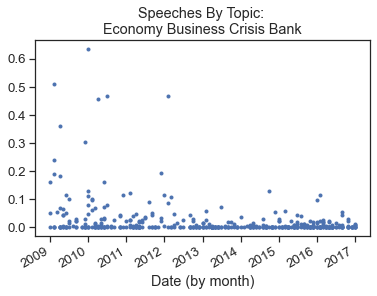

In [142]:
topic_number = 5

topic_label = " ".join(topics[topic_number][:4])

df_speech[topic_label].plot(style='.', title=f'Speeches By Topic: \n{topic_label.title()}')

<AxesSubplot:title={'center':'Speeches By Topic: \nHealth Care Insurance People'}, xlabel='Date (by month)'>

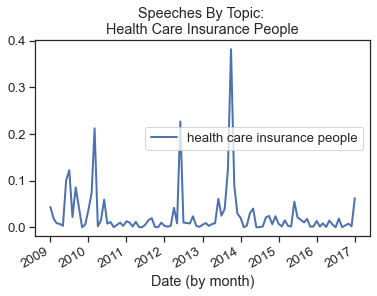

In [143]:
topic_number = 13

topic_label = " ".join(topics[topic_number][:4])

df_speech.groupby(df_speech.index)[[topic_label]].mean().plot(title=f'Speeches By Topic: \n{topic_label.title()}', linewidth=2)

<AxesSubplot:title={'center':'Speeches By Topic: \nWar People Security Force'}, xlabel='Date (by month)'>

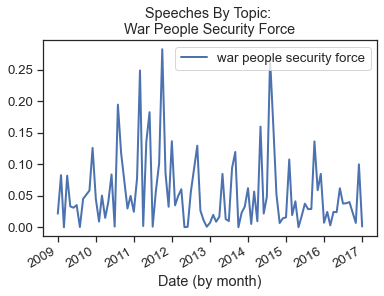

In [146]:
topic_number = 3

topic_label = " ".join(topics[topic_number][:4])

df_speech.groupby(df_speech.index)[[topic_label]].mean().plot(title=f'Speeches By Topic: \n{topic_label.title()}', linewidth=2)

<AxesSubplot:title={'center':'Speeches By Topic: \nEnergy Oil Change Gas'}, xlabel='Date (by month)'>

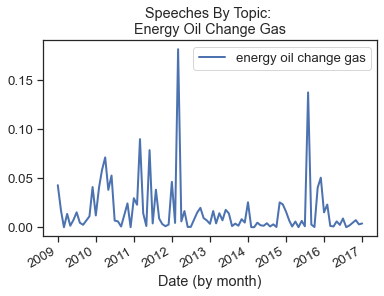

In [147]:
topic_number = 19

topic_label = " ".join(topics[topic_number][:4])

df_speech.groupby(df_speech.index)[[topic_label]].mean().plot(title=f'Speeches By Topic: \n{topic_label.title()}', linewidth=2)

<AxesSubplot:title={'center':'Speeches By Topic: \nJob Work School College'}, xlabel='Date (by month)'>

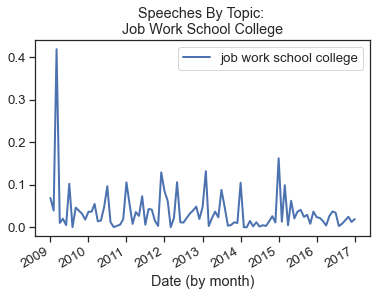

In [148]:
topic_number = 27

topic_label = " ".join(topics[topic_number][:4])

df_speech.groupby(df_speech.index)[[topic_label]].mean().plot(title=f'Speeches By Topic: \n{topic_label.title()}', linewidth=2)